In [1]:
# Suppress warnings (This is only to keep the notebook pretty. You might want to comment the below two lines)
import warnings

warnings.filterwarnings("ignore")

# - Import statements
import torch
import samna

import time
from tqdm.auto import tqdm
import numpy as np
import torch.nn as nn
from torchvision import datasets
import sinabs
from sinabs.from_torch import from_model
from sinabs.backend.dynapcnn import io
from sinabs.backend.dynapcnn import DynapcnnNetwork
from sinabs.backend.dynapcnn.chip_factory import ChipFactory
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

assert samna.__version__ >= '0.21.8', f"samna version {samna.__version__} is too low for this experiment"

接下来定义一个简单的卷积神经网络结构。这里我们需要提前将ANN训练好并保存模型文件。

In [2]:
# - Define CNN model

ann = nn.Sequential(
    nn.Conv2d(1, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False),
)

# Load pre-trained weights
ann.load_state_dict(torch.load("./mnist_net.pth", map_location="cpu"))


<All keys matched successfully>

In [3]:
# Define custom dataset for spiking input data
class MNIST_Dataset(datasets.MNIST):

    def __init__(self, root, train = True, spiking=False, tWindow=100):
        super().__init__(root, train=train, download=True)
        self.spiking=spiking
        self.tWindow = tWindow


    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        if self.spiking:
            img = (np.random.rand(self.tWindow, 1, *img.size()) < img.numpy()/255.0).astype(float)
            img = torch.from_numpy(img).float()
        else:
            # Convert image to tensor
            img = torch.from_numpy(img.numpy()).float()
            img.unsqueeze_(0)

        return img, target


# Define dataloader
tWindow = 200 # ms (or) time steps

# Define test dataset
test_dataset = MNIST_Dataset("./data", train=False, spiking=True, tWindow=tWindow)
test_dataloader = DataLoader(test_dataset, batch_size=1)

param_layers = [name for name, child in ann.named_children() if isinstance(child, (nn.Conv2d, nn.Linear))]
output_layers = [name for name, child in ann.named_children() if isinstance(child, nn.ReLU)]
output_layers += [param_layers[-1]]
normalise_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)
sample_data = next(iter(normalise_loader))[0].flatten(0, 1)
percentile = 99.99


sinabs.utils.normalize_weights(ann, sample_data, output_layers=output_layers, param_layers=param_layers, percentile=percentile)

In [4]:
sinabs_model = from_model(ann, add_spiking_output=True, min_v_mem=-1, batch_size=1)
print(sinabs_model.spiking_model)

print(sinabs_model.spiking_model[1].min_v_mem)


Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1, batch_size=1, num_timesteps=-1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1, batch_size=1, num_timesteps=-1)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1, batch_size=1, num_timesteps=-1)
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=128, out_features=500, bias=False)
  (11): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1, batch_size=1, num_timesteps=-1)
  (12): Linear(in_features=500, out_features=10, bias=False)
  (spike_output): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1, batch_size=1, num_timesteps=-1)
)
Parameter containing

In [5]:
# - Input dimensions
input_shape = (1, 28, 28)

device = "speck2edevkit:0"

# - DYNAP-CNN compatible network
dynapcnn_net = DynapcnnNetwork(
    sinabs_model.spiking_model,
    input_shape=input_shape,
    discretize=True,
    dvs_input=False,
)
print(dynapcnn_net)





DynapcnnNetwork(
  (sequence): Sequential(
    (0): DVSLayer(
      (pool_layer): SumPool2d(norm_type=1, kernel_size=(1, 1), stride=None, ceil_mode=False)
      (crop_layer): Crop2d((0, 28), (0, 28))
      (flip_layer): FlipDims()
    )
    (1): DynapcnnLayer(
      (conv_layer): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (spk_layer): IAFSqueeze(spike_threshold=581.0, min_v_mem=-581.0, batch_size=1, num_timesteps=-1)
      (pool_layer): SumPool2d(norm_type=1, kernel_size=(2, 2), stride=None, ceil_mode=False)
    )
    (2): DynapcnnLayer(
      (conv_layer): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (spk_layer): IAFSqueeze(spike_threshold=924.0, min_v_mem=-924.0, batch_size=1, num_timesteps=-1)
      (pool_layer): SumPool2d(norm_type=1, kernel_size=(2, 2), stride=None, ceil_mode=False)
    )
    (3): DynapcnnLayer(
      (conv_layer): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (spk_layer): IAFSqueeze(spike_thres

In [6]:
with torch.no_grad():
    correct = 0
    samples = 0
    # we will only use the first 100 samples to save some time
    pbar = tqdm(test_dataset, total=100)
    for data, label in pbar:
        dynapcnn_net.reset_states()
        out = dynapcnn_net(data)

        # Calculate total number of spikes out
        pred = out.squeeze().sum(0)
        # print(pred.shape)
        
        # Check if the prediction matches the label
        if pred.argmax() == label:
            correct += 1
        samples += 1
        pbar.set_postfix(acc=100*correct/samples)
        if samples >= 100:
            break

f"Accuracy of the  dynapcnn_net is: {100*correct/samples}%"

 99%|█████████▉| 99/100 [00:09<00:00, 10.19it/s, acc=73]  


'Accuracy of the  dynapcnn_net is: 73.0%'

Configuration method 1

In [7]:
# Apply model to device such as dynapcnndevkit, speck2, speck2b

# dynapcnn_net.to(device)

# print(dynapcnn_net)
# print(dynapcnn_net.chip_layers_ordering)

In [8]:
# dynapcnn_net.memory_summary()

# builder = ChipFactory(device).get_config_builder()
# builder.get_constraints()



In [9]:
# correct_on = 0
# samples_on = 0
# pbar = tqdm(test_dataset, total=100)
# factory = ChipFactory(device)
# first_layer_idx = dynapcnn_net.chip_layers_ordering[0] 

# for data, label in pbar:
#     dynapcnn_net.reset_states()
#     events_in = factory.raster_to_events(data, layer=first_layer_idx)

#     output = dynapcnn_net(events_in)
#     if output:
#         out = factory.events_to_raster(output)
#         pred = out.squeeze().sum(0)

#         if pred.argmax() == label:
#             correct_on += 1
#         samples_on += 1
#         pbar.set_postfix(acc=100*correct_on/samples_on)
#     else:
#         print("none")
#     if samples_on >= 100:
#         break

# f"Accuracy of the  dynapcnn_net is: {100*correct_on/samples_on}%"

In [10]:
# raster, label = test_dataset[0]

# factory = ChipFactory(device)
# first_layer_idx = dynapcnn_net.chip_layers_ordering[0] 
# events_in = factory.raster_to_events(raster, layer=first_layer_idx)
# print(events_in)

# dynapcnn_net.reset_states()
# time.sleep(6.0)  # wait until the configuration take effect, this step is necessary when use a speck2edevkit!
# print(dynapcnn_net)
# events_out = dynapcnn_net(events_in)
# print(events_out)

In [11]:
# output = factory.events_to_raster(events_out)
# output.sum([0,2,3])
# print(output)
# print(label)

Configuration method 2

In [12]:
samna_cfg = dynapcnn_net.make_config(
    device= device,
    chip_layers_ordering="auto",
    monitor_layers= [-1]
)

print(dynapcnn_net.chip_layers_ordering)

Network is valid
[0, 3, 5, 6, 1]


In [13]:
devkit = samna.device.open_device("Speck2eDevKit:0")

# get the handle of the stop-watch of the devkit
stop_watch = devkit.get_stop_watch()

# get the handle of the power monitor of the devkit
power_monitor = devkit.get_power_monitor()

# create samna node for power reading
power_source_node = power_monitor.get_source_node()
power_buffer_node = samna.BasicSinkNode_unifirm_modules_events_measurement()

samna_graph = samna.graph.EventFilterGraph()

# build graph
samna_graph.sequential([power_source_node, power_buffer_node])
time.sleep(0.5)

# 初始化源节点和溯节点
input_buffer_node = samna.BasicSourceNode_speck2e_event_speck2e_input_event()
spike_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()

_, br = samna_graph.sequential(
    [
        input_buffer_node,
        devkit.get_model_sink_node(),
    ]
)

_, type_filter_node_spike, _ = samna_graph.sequential(
    [
        devkit.get_model_source_node(),
        "Speck2eOutputEventTypeFilter",
        spike_buffer_node,
    ]
)

type_filter_node_spike.set_desired_type("speck2e::event::Spike")

measure_time = 5.0  # seconds
sample_rate = 100.0  # Hz

samna_graph.start()

True

In [14]:
raster, label = test_dataset[0]

factory = ChipFactory(device)
first_layer_idx = dynapcnn_net.chip_layers_ordering[0]
events_in = factory.raster_to_events(raster, layer=first_layer_idx)

print(int(label))

7


In [15]:
devkit.get_model().apply_configuration(samna_cfg)
time.sleep(6.0)

stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()

time.sleep(1.0)

spike_buffer_node.get_events()
input_buffer_node.write(events_in)



In [16]:
# samna.speck2e.Speck2eModel.reset
# time.sleep(3.0)

output_spike_events = spike_buffer_node.get_events()

def check_output_spikes(output_spikes: list, output_layer_idx: int):
    for spk in output_spikes:
        assert spk.layer == output_layer_idx
        assert isinstance(spk, samna.speck2e.event.Spike)
    print("All spike events correct!")

    return

check_output_spikes(output_spike_events, dynapcnn_net.chip_layers_ordering[-1])
print("num of spike events: ", len(output_spike_events))
print(output_spike_events)

All spike events correct!
num of spike events:  0
[]


In [17]:
def convert_output_spike_into_prediction(spk_events: list) -> np.ndarray:

    num_class = 10

    count = np.zeros(num_class)

    for spk in spk_events:
        class_idx = spk.feature
        count[class_idx] += 1
    return count

prediction_array = convert_output_spike_into_prediction(output_spike_events)

print(prediction_array)
print("预测标签为： ", prediction_array.argmax(), "标签为： ", label)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
预测标签为：  0 标签为：  tensor(7)


In [18]:
correct_on = 0
samples_on = 0
pbar = tqdm(test_dataset, total=100)

for raster, label in pbar:


    events_in = factory.raster_to_events(raster, layer=first_layer_idx)
    spike_buffer_node.get_events()
    input_buffer_node.write(events_in)
    time.sleep(3.0)

    output_spike_events = spike_buffer_node.get_events()
    if not output_spike_events:
        break
    prediction_array = convert_output_spike_into_prediction(output_spike_events)
    # print(prediction_array)
    # print("预测标签为： ", prediction_array.argmax(), "标签为： ", int(label))
    if prediction_array.argmax() == int(label):
        correct_on +=1
    samples_on +=1
    if samples_on >= 100:
        break
f"Accuracy of the  dynapcnn_net is: {100*correct_on/samples_on}%"

 19%|█▉        | 19/100 [01:06<04:44,  3.51s/it]


'Accuracy of the  dynapcnn_net is: 21.05263157894737%'

In [19]:
def convert_output_spike_into_prediction(spk_events: list) -> np.ndarray:

    num_class = 10

    count = np.zeros(num_class)

    for spk in spk_events:
        class_idx = spk.feature
        count[class_idx] += 1
    return count

def check_output_spikes(output_spikes: list, output_layer_idx: int):
    for spk in output_spikes:
        assert spk.layer == output_layer_idx
        assert isinstance(spk, samna.speck2e.event.Spike)
    print("All spike events correct!")

    return

In [20]:

samna.speck2e.Speck2eModel.reset
time.sleep(3.0)

devkit = samna.device.open_device("Speck2eDevKit:0")

# get the handle of the power monitor of the devkit
power_monitor = devkit.get_power_monitor()

# create samna node for power reading
power_source_node = power_monitor.get_source_node()
power_buffer_node = samna.BasicSinkNode_unifirm_modules_events_measurement()

samna_graph = samna.graph.EventFilterGraph()

    # 初始化源节点和溯节点
input_buffer_node = samna.BasicSourceNode_speck2e_event_speck2e_input_event()
spike_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()

samna_graph.sequential([power_source_node, power_buffer_node])

_, br = samna_graph.sequential(
    [
        input_buffer_node,
        devkit.get_model_sink_node(),
    ]
)

_, type_filter_node_spike, _ = samna_graph.sequential(
    [
        devkit.get_model_source_node(),
        "Speck2eOutputEventTypeFilter",
        spike_buffer_node,
    ]
)

type_filter_node_spike.set_desired_type("speck2e::event::Spike")

samna_graph.start()

raster, label = test_dataset[0]

factory = ChipFactory(device)
first_layer_idx = dynapcnn_net.chip_layers_ordering[0]
events_in = factory.raster_to_events(raster, layer=first_layer_idx)

print(int(label))

devkit.get_model().apply_configuration(samna_cfg)
time.sleep(6.0)

stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()

time.sleep(1.0)

# start monitor, we need pass a sample rate argument to the power monitor
power_monitor.start_auto_power_measurement(sample_rate)

# clear buffer
power_buffer_node.get_events()

spike_buffer_node.get_events()
input_buffer_node.write(events_in)

# samna.speck2e.Speck2eModel.reset
# time.sleep(3.0)

output_spike_events = spike_buffer_node.get_events()



check_output_spikes(output_spike_events, dynapcnn_net.chip_layers_ordering[-1])
print("num of spike events: ", len(output_spike_events))
print(output_spike_events)

# clear buffer
power_buffer_node.get_events()

spike_buffer_node.get_events()
input_buffer_node.write(events_in)

# samna.speck2e.Speck2eModel.reset
# time.sleep(3.0)

output_spike_events = spike_buffer_node.get_events()



check_output_spikes(output_spike_events, dynapcnn_net.chip_layers_ordering[-1])
print("num of spike events: ", len(output_spike_events))
print(output_spike_events)

# clear buffer
power_buffer_node.get_events()

spike_buffer_node.get_events()
input_buffer_node.write(events_in)

# samna.speck2e.Speck2eModel.reset
# time.sleep(3.0)

output_spike_events = spike_buffer_node.get_events()



check_output_spikes(output_spike_events, dynapcnn_net.chip_layers_ordering[-1])
print("num of spike events: ", len(output_spike_events))
print(output_spike_events)




prediction_array = convert_output_spike_into_prediction(output_spike_events)

print(prediction_array)
print("预测标签为： ", prediction_array.argmax(), "标签为： ", label)

# sleep the procees to wait for the measurement time up
time.sleep(measure_time)

# stop monitor
power_monitor.stop_auto_power_measurement()

# stop samna graph
samna_graph.stop()

# get power-measurement data
power_events = power_buffer_node.get_events()

# time * sample rate * number of power tracks
estimated_number_of_data = measure_time * sample_rate * 5
print(f"estimated number of collect data: {estimated_number_of_data}")

print(f"number of collected data: {len(power_events)}")



7
All spike events correct!
num of spike events:  0
[]
All spike events correct!
num of spike events:  0
[]
All spike events correct!
num of spike events:  0
[]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
预测标签为：  0 标签为：  tensor(7)
estimated number of collect data: 2500.0
number of collected data: 2499


In [21]:
num_power_tracks = 5

# init dict for storing data of each power track
power_each_track = dict()
event_count_each_track = dict()

# check whether timestamp is correct
timestamp_all_zero = True

# loop through all collected power events and get data
for evt in power_events:

    if evt.timestamp != 0:
        timestamp_all_zero = False
    
    p_track_id = evt.channel
    tmp_power = power_each_track.get(p_track_id, 0) + evt.value
    tmp_count = event_count_each_track.get(p_track_id, 0) + 1
    
    power_each_track.update({p_track_id: tmp_power})
    event_count_each_track.update({p_track_id: tmp_count})

# average power and current of each track
for p_track_id in range(num_power_tracks):
    
    # average power in microwatt
    avg_power = power_each_track[p_track_id] / event_count_each_track[p_track_id] * 1e6
    # calculate current
    if p_track_id == 0:
        current = avg_power / 2.5 
    else:
        current = avg_power / 1.2
        
    print(f'track{p_track_id}: {avg_power}uW, {current}uA')

track0: 55.51629638671878uW, 22.206518554687513uA
track1: 4001.652832031249uW, 3334.7106933593745uA
track2: 5413.8783482142835uW, 4511.56529017857uA
track3: 162.30678013392858uW, 135.25565011160717uA
track4: 598.6893569505086uW, 498.90779745875716uA


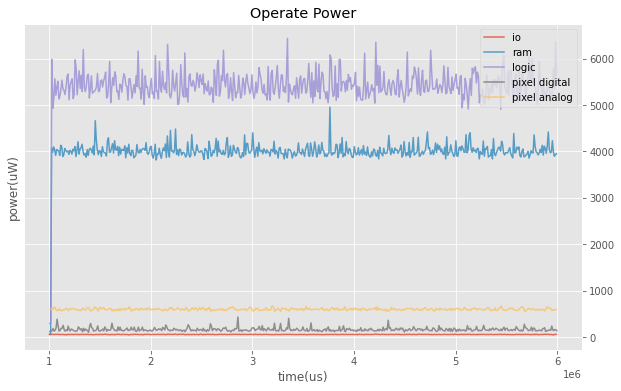

In [22]:
if timestamp_all_zero:
    
    print("timestamps are all zeros, can't plot power vs. time, you might need to update the firmware!")
    
else:
    plt.rcParams['figure.figsize']=(10, 6)
    plt.rcParams['axes.facecolor']='white'
    # plot the output neuron index vs. time
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    p_track_name = ["io", "ram", "logic", "pixel digital", "pixel analog"]
    for p_track_id in range(num_power_tracks):
        x = [each.timestamp for each in power_events if each.channel == p_track_id]
        y = [each.value * 1e6 for each in power_events if each.channel == p_track_id]
        plt.plot(x, y, label=p_track_name[p_track_id], alpha=0.8)
        
    ax.set_xlabel("time(us)")
    ax.set_ylabel("power(uW)")
    ax.set_title("Operate Power")
    ax.legend(loc="upper right", fontsize=10)
    ax.yaxis.tick_right()
    # ax.set_facecolor('grey')
    ax.set_alpha(1)
    plt.savefig("./operate.png")
    plt.savefig("./operate.svg")
    plt.show()
    

In [23]:
correct_on = 0
samples_on = 0
pbar = tqdm(test_dataset, total=100)

for raster, label in pbar:



    events_in = factory.raster_to_events(raster, layer=first_layer_idx)
    spike_buffer_node.get_events()
    input_buffer_node.write(events_in)
    time.sleep(3.0)

    output_spike_events = spike_buffer_node.get_events()
    if not output_spike_events:
        break
    prediction_array = convert_output_spike_into_prediction(output_spike_events)
    # print(prediction_array)
    # print("预测标签为： ", prediction_array.argmax(), "标签为： ", int(label))
    if prediction_array.argmax() == int(label):
        correct_on +=1
    samples_on +=1
    if samples_on >= 100:
        break
f"Accuracy of the  dynapcnn_net is: {100*correct_on/samples_on}%"

  0%|          | 0/100 [00:03<?, ?it/s]


ZeroDivisionError: division by zero

In [ ]:
# close devkit after experiment finished
samna.device.close_device(devkit)